In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [2]:
world_df = pd.read_csv('world.csv')
life_df = pd.read_csv('life.csv')

world_df['Year'] = world_df['Year'].astype(str)
life_df['Year'] = life_df['Year'].astype(str)

merged_df = pd.merge(world_df, life_df, on=['CountryName', 'CountryCode', 'Year'])
merged_df.sort_values(by=['CountryName'], inplace=True)
merged_df.dropna(subset=['CountryName'],inplace=True)
print(merged_df.head())

           CountryName  Year CountryCode  \
0          Afghanistan  2016         AFG   
1              Albania  2016         ALB   
2              Algeria  2016         DZA   
3               Angola  2016         AGO   
4  Antigua and Barbuda  2016         ATG   

  Access to electricity (% of population) [EG.ELC.ACCS.ZS]  \
0                                               97.7         
1                                                100         
2                                         99.9923172         
3                                        40.62452698         
4                                                100         

  Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD]  \
0                                        465.8415828                          
1                                        3776.111694                          
2                                        3284.470252                          
3                                         1949

In [3]:
#task 1A
X=merged_df.drop(columns=['CountryName', 'CountryCode', 'Year', 'Life expectancy at birth (years)'])
y=merged_df['Life expectancy at birth (years)']
#训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200)  #测试训练三七分
X_train=X_train.replace('..',np.nan)
X_test=X_test.replace('..',np.nan)  #将..替换为nan
#用中位数填充nan
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
#标准化
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
#knn分类器
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_7 = KNeighborsClassifier(n_neighbors=7)
knn_3.fit(X_train_scaled, y_train)
knn_7.fit(X_train_scaled, y_train)
#决策树分类器
dt=DecisionTreeClassifier(max_depth=3)
dt.fit(X_train_scaled, y_train)
#测试分类器
y_pred_knn_3 = knn_3.predict(X_test_scaled)
y_pred_knn_7 = knn_7.predict(X_test_scaled)
y_pred_dt = dt.predict(X_test_scaled)
#计算准确率
accuracy_knn_3 = accuracy_score(y_test, y_pred_knn_3)
accuracy_knn_7 = accuracy_score(y_test, y_pred_knn_7)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'k-NN (k=3) 的准确率:{accuracy_knn_3}')
print(f'k-NN (k=7) 的准确率:{accuracy_knn_7}')
print(f'决策树的准确率:{accuracy_dt}')

k-NN (k=3) 的准确率:0.6041666666666666
k-NN (k=7) 的准确率:0.6041666666666666
决策树的准确率:0.7708333333333334


In [4]:
#这里再试试XGBoost模型
from sklearn.model_selection import GridSearchCV
# 对目标变量进行编码
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
#定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
#获取最佳模型
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train_encoded)
#输出最佳参数和准确率
print(f'最佳参数:{grid_search.best_params_}')
print(f'最佳准确率:{grid_search.best_score_}')
#最佳模型
best_xgb=grid_search.best_estimator_
best_xgb.fit(X_train_scaled, y_train_encoded)
#测试模型
y_pred_xgb = best_xgb.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'XGBoost 的准确率:{accuracy_xgb}')

Fitting 3 folds for each of 324 candidates, totalling 972 fits
最佳参数:{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}
最佳准确率:0.755005005005005
XGBoost 的准确率:0.75


d:\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:26:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [5]:
#random forest模型
from sklearn.ensemble import RandomForestClassifier
#定义参数网格
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
#获取最佳模型
rf_model = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_scaled, y_train_encoded)
# 获取最佳超参数组合
print(f'最佳超参数组合: {grid_search_rf.best_params_}')
print(f'最佳准确率: {grid_search_rf.best_score_}')
#最佳模型
best_rf=grid_search_rf.best_estimator_
best_rf.fit(X_train_scaled, y_train_encoded)
#测试模型
y_pred_rf = best_rf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
print(f'Random Forest 的准确率:{accuracy_rf}')

Fitting 3 folds for each of 216 candidates, totalling 648 fits
最佳超参数组合: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
最佳准确率: 0.7735235235235235
Random Forest 的准确率:0.7291666666666666


In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [15]:
interaction_terms = pd.DataFrame()  #创建聚类特征
for i in range(X_train.shape[1]):
    for j in range(i+1, X_train.shape[1]):
        interaction_terms[f'interaction_{i}_{j}'] = X_train_imputed[:, i] * X_train_imputed[:, j]
kmeans_pca = KMeans(n_clusters=3, random_state=200)  #kmeans聚类
cluster_labels = kmeans_pca.fit_predict(X_train_scaled)  #训练
#合并聚类特征
#确保列名为字符串
interaction_terms.columns = interaction_terms.columns.astype(str)
X_train_scaled_df = pd.DataFrame(X_train_scaled)
X_train_scaled_df.columns = X_train_scaled_df.columns.astype(str)
#合并
X_train_extended = pd.concat([X_train_scaled_df, interaction_terms, pd.DataFrame(cluster_labels, columns=['cluster_label'])], axis=1)
pca=PCA(n_components=4)  
X_train_pca = pca.fit_transform(X_train_extended)
x_train_selected = X_train_pca[:, :4]  #选择前4,减少维度

C:\Users\l'zh\AppData\Local\Temp\ipykernel_18424\2062346616.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interaction_terms[f'interaction_{i}_{j}'] = X_train_imputed[:, i] * X_train_imputed[:, j]
C:\Users\l'zh\AppData\Local\Temp\ipykernel_18424\2062346616.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interaction_terms[f'interaction_{i}_{j}'] = X_train_imputed[:, i] * X_train_imputed[:, j]
C:\Users\l'zh\AppData\Local\Temp\ipykernel_18424\2062346616.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [16]:
# 特征选择
#from sklearn.feature_selection import SelectKBest, f_classif
# #在进行 PCA 之前，使用相关系数、卡方检验或基于树模型的特征重要性等方法，选择与目标变量相关性较高的特征，去除无关或冗余特征。
# selector = SelectKBest(score_func=f_classif, k=10)
# X_train_selected = selector.fit_transform(X_train_scaled, y_train_encoded)
# X_test_selected = selector.transform(X_test_scaled)

# # 考虑使用线性判别分析（LDA）等监督式降维方法，运用目标变量的信息，提高类别可分性
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# lda = LinearDiscriminantAnalysis(n_components=2)
# X_train_lda = lda.fit_transform(X_train_selected, y_train_encoded)
# X_test_lda = lda.transform(X_test_selected)

# 训练模型
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_selected, y_train_encoded)
y_pred_knn = knn.predict(X_test_selected)
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)
print(f'k-NN 的准确率: {accuracy_knn}')

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train_selected, y_train_encoded)
y_pred_dt = dt.predict(X_test_selected)
accuracy_dt = accuracy_score(y_test_encoded, y_pred_dt)
print(f'决策树的准确率: {accuracy_dt}')

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_selected, y_train_encoded)
y_pred_xgb = xgb.predict(X_test_selected)
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'XGBoost 的准确率: {accuracy_xgb}')

rf = RandomForestClassifier()
rf.fit(X_train_selected, y_train_encoded)
y_pred_rf = rf.predict(X_test_selected)
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
print(f'Random Forest 的准确率: {accuracy_rf}')

k-NN 的准确率: 0.6875
决策树的准确率: 0.6666666666666666
XGBoost 的准确率: 0.7083333333333334


d:\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest 的准确率: 0.75


### 下面是copilot的建议
1.数据质量和预处理

标签编码问题：在您的代码中，您使用了 LabelEncoder 对目标变量进行了编码。然而，LabelEncoder 可能会将类别映射为整数（例如，High→2，Medium→1，Low→0）。如果目标变量中类别分布不均衡，模型可能会受到类别编码的影响。

类别不平衡：如果数据集中存在类别不平衡的问题（例如，High 类的样本数量远多于 Low 类），那么模型可能会倾向于预测多数类，导致准确率下降。

2.特征选择和降维

特征选择方法不合适：您使用了 SelectKBest 和 f_classif 进行特征选择，但 f_classif 适用于二分类问题，对于多分类问题可能不够有效。

降维导致信息丢失：使用 PCA（无监督降维）或 LDA（监督降维）可能会丢失对分类任务重要的信息，尤其是在特征本身并没有明显的线性关系时。

3.模型复杂度和过拟合

模型过拟合：复杂的模型（如 XGBoost、随机森林）可能会在训练数据上过拟合，无法泛化到测试数据。

参数调整不当：模型的超参数可能没有经过充分的调优，导致模型性能未达到最佳。

4.评估指标选择

仅关注准确率：准确率在类别不平衡的数据集上可能具有误导性。需要使用更加全面的评估指标（如精确率、召回率、F1-score）来评估模型性能。

决策树分类报告：
              precision    recall  f1-score   support

        High       0.71      0.85      0.77        20
         Low       0.75      0.86      0.80        14
      Medium       0.62      0.36      0.45        14

    accuracy                           0.71        48
   macro avg       0.69      0.69      0.68        48
weighted avg       0.70      0.71      0.69        48



d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20915 (\N{CJK UNIFIED IDEOGRAPH-51B3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.p

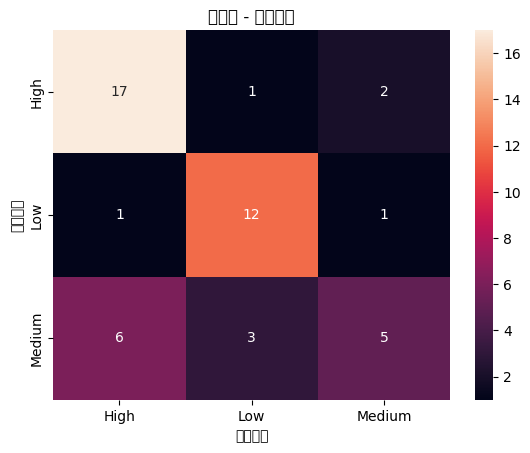

In [13]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# 读取数据
world_df = pd.read_csv('world.csv')
life_df = pd.read_csv('life.csv')

# 数据预处理
world_df['Year'] = world_df['Year'].astype(str)
life_df['Year'] = life_df['Year'].astype(str)
merged_df = pd.merge(world_df, life_df, on=['CountryName', 'CountryCode', 'Year'])
merged_df.dropna(subset=['CountryName'], inplace=True)

# 特征和标签
X = merged_df.drop(columns=['CountryName', 'CountryCode', 'Year', 'Life expectancy at birth (years)'])
y = merged_df['Life expectancy at birth (years)']

# 标签编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# 将非数值数据替换为NaN
X_train = X_train.replace('..', np.nan)
X_test = X_test.replace('..', np.nan)

# 处理缺失值
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 特征缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 处理类别不平衡
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 特征选择（基于随机森林的重要性）
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]  # 选择15个重要特征
X_train_selected = X_train_resampled[:, indices]
X_test_selected = X_test_scaled[:, indices]

# 模型训练和评估
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
dt.fit(X_train_selected, y_train_resampled)
y_pred_dt = dt.predict(X_test_selected)

print("决策树分类报告：")
print(classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_))

# 混淆矩阵
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('决策树 - 混淆矩阵')
plt.show()